This file compiles a new csv with every shot taken in the top five leagues

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [14]:
dir1 = ""

# read in teams.csv
filename = dir1 + r"base_data/teams.csv"
df_teams = pd.read_csv(filename)

# read in leagues.csv
filename = dir1 + r"base_data/leagues.csv"
df_leagues = pd.read_csv(filename)

# read in teamStats.csv
filename = dir1 + r"base_data/teamStats.csv"
df_teamStats = pd.read_csv(filename)

# read in fixtures.csv
filename = dir1 + r"base_data/fixtures.csv"
df_fixtures = pd.read_csv(filename)

# read in players.csv
filename = dir1 + r"base_data/players.csv"
df_players = pd.read_csv(filename)

# read in keyEventDescription.csv
filename = dir1 + r"base_data/keyEventDescription.csv"
df_keyEventDescription = pd.read_csv(filename)

C:\Users\caele\AppData\Local\Temp\ipykernel_17776\2743355242.py:21: DtypeWarning: Columns (2,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_players = pd.read_csv(filename)


Features we care about: eventId, teamId, playerId, freekick, penalty, x_loc, y_loc, goal?, player position, time?

In [15]:
# only look at teamStats from top five leagues
valid_leagues = ["English Premier League", "French Ligue 1", "Spanish LALIGA", "Italian Serie A", "German Bundesliga"]
valid_leagueIds = list(df_leagues[df_leagues['leagueName'].apply(lambda x: x in valid_leagues)]['leagueId'])
valid_leagueMidsizeNames = list(df_leagues[df_leagues['leagueName'].apply(lambda x: x in valid_leagues)]['midsizeName'])
valid_events = list(df_fixtures[df_fixtures['leagueId'].apply(lambda x: x in valid_leagueIds)]['eventId'])

In [16]:
df_keyEventDescription

,keyEventTypeId,keyEventName
0,66,Foul
1,68,Offside
2,70,Goal
3,74,Shot
4,76,Substitution
5,77,Save
6,78,Assist
7,80,Kickoff
8,81,Halftime
9,82,Start 2nd Half


In [28]:
# what id is a goal?
# don't forget events are logged multiple times
goalIds = [70, 137, 138, 173]
shotIds = [74, 106, 117, 140, 136, 135]
penalty_missIds = [174, 140, 115, 114, 113]
penalty_scoreIds = [104, 98]

In [18]:
# load all plays
fname = "plays_data/plays_" + str(2024) + "_" + valid_leagueMidsizeNames[0] + ".csv"
df_plays = pd.read_csv(fname)
for mid_name in valid_leagueMidsizeNames[1:]:
    fname = "plays_data/plays_" + str(2024) + "_" + mid_name + ".csv"
    df_temp = pd.read_csv(fname)
    df_plays = pd.concat([df_plays, df_temp], ignore_index=True)
print(df_plays.shape)
df_plays = df_plays[df_plays['eventId'].apply(lambda x: x in valid_events)]
print(df_plays.shape)
del df_temp

(166191, 23)
(166191, 23)


In [19]:
is_goal = df_plays['typeId'].apply(lambda x: x in goalIds)
is_shot = df_plays['typeId'].apply(lambda x: x in shotIds)
df_shots = df_plays[is_shot | is_goal].copy()
df_shots['isGoal'] = is_goal

In [30]:
is_missed_pen = df_plays['typeId'].apply(lambda x: x in penalty_missIds)
is_scored_pen = df_plays['typeId'].apply(lambda x: x in penalty_scoreIds)
pen_conversion_rate = np.sum(is_scored_pen) / (np.sum(is_scored_pen) + np.sum(is_missed_pen))
print("penalty conversion rate: " + str(pen_conversion_rate))

penalty conversion rate: 0.7860576923076923


In [8]:
# delete duplicate playIds
df_shots = df_shots.drop_duplicates(subset=['playId'], keep='first')
print(df_shots.shape)

(31460, 24)


In [9]:
goal_y_bounds = [0.43, 0.57]
def distance_to_goal(x, y):
    """Returns distance to nearest point on the goal"""
    # rescale
    x *= 60
    y *= 80
    if y < min(goal_y_bounds):
        return np.sqrt(x**2 + (0.43*80 - y)**2) # distance to front post
    elif y > max(goal_y_bounds):
        return np.sqrt(x**2 + (y - 0.57*80)**2)
    else:
        return x

def angle_of_shot(x, y, x2, y2):
    """Returns the direction of the shot relative to pointing straight at the goalline.
    I may have flipped the x-axis >:-)
    """
    vec = np.array([x - x2, y - y2])
    goal_vec = np.array([1, 0])
    return np.arccos(vec@goal_vec/(np.linalg.norm(vec)*np.linalg.norm(goal_vec)))

def angle_to_goal(x, y):
    # rescale
    x *= 60
    y *= 80
    """Returns the angle to the nearest point on the goal"""
    if y < min(goal_y_bounds):
        return angle_of_shot(x, y, 0, 0.43*60)
    elif y > max(goal_y_bounds):
        return angle_of_shot(x, y, 0, 0.57*80)
    else:
        return 0

In [10]:
df_shots['shotDistance'] = df_shots.apply(lambda row: distance_to_goal(row['fieldpositionX'], row['fieldPositionY']), axis=1)
df_shots['shotAngle'] = df_shots.apply(lambda row: angle_to_goal(row['fieldpositionX'], row['fieldPositionY']), axis=1)
df_shots.head(10)

,seasonType,eventId,playOrder,playId,typeId,text,shortText,period,clockValue,clockDisplayValue,...,fieldpositionX,fieldPositionY,fieldPosition2X,fieldPosition2Y,athleteId,participant,updateDateTime,isGoal,shotDistance,shotAngle
6,12654,704279,5,43556252,117,Attempt missed. Adama Traoré (Fulham) right fo...,Adama Traoré Shot Off Target,1,467,8',...,0.266,0.722,0.000,0.555,220626.0,Adama Traoré,2024-08-18 05:55:35,False,20.064576,0.651077
10,12654,704279,7,43556314,106,Attempt saved. Kenny Tete (Fulham) right foote...,Kenny Tete Shot On Target,1,737,13',...,0.546,0.499,0.046,0.505,190974.0,Kenny Tete,2024-08-18 05:55:35,False,33.248759,0.171675
13,12654,704279,9,43556339,135,Attempt blocked. Rodrigo Muniz (Fulham) header...,Rodrigo Muniz Shot Blocked,1,787,14',...,0.222,0.544,0.142,0.520,301525.0,Rodrigo Muniz,2024-08-18 05:55:35,False,13.481424,0.154905
21,12654,704279,14,43556437,117,Attempt missed. Bruno Fernandes (Manchester Un...,Bruno Fernandes Shot Off Target,1,1176,20',...,0.000,0.000,0.000,0.000,124091.0,Bruno Fernandes,2024-08-18 05:55:35,False,34.400000,1.570796
28,12654,704279,18,43556512,117,Attempt missed. Casemiro (Manchester United) r...,Casemiro Shot Off Target,1,1577,27',...,0.506,0.521,0.000,0.434,173666.0,Casemiro,2024-08-18 05:55:35,False,30.612024,0.128407
30,12654,704279,19,43556527,106,Attempt saved. Bruno Fernandes (Manchester Uni...,Bruno Fernandes Shot On Target,1,1693,29',...,0.246,0.660,0.136,0.590,124091.0,Bruno Fernandes,2024-08-18 05:55:35,False,16.422472,0.453844
34,12654,704279,21,43556635,106,Attempt saved. Bruno Fernandes (Manchester Uni...,Bruno Fernandes Shot On Target,1,2037,34',...,0.172,0.521,0.124,0.516,124091.0,Bruno Fernandes,2024-08-18 05:55:35,False,11.039420,0.363012
38,12654,704279,23,43556669,117,Attempt missed. Casemiro (Manchester United) h...,Casemiro Shot Off Target,1,2179,37',...,0.086,0.415,0.000,0.435,173666.0,Casemiro,2024-08-18 05:55:35,False,13.430771,1.176463
45,12654,704279,28,43556761,117,Attempt missed. Casemiro (Manchester United) r...,Casemiro Shot Off Target,1,2491,42',...,0.000,0.000,0.000,0.000,173666.0,Casemiro,2024-08-18 05:55:35,False,34.400000,1.570796
50,12654,704279,32,43557004,117,Attempt missed. Alex Iwobi (Fulham) header fro...,Alex Iwobi Shot Off Target,2,2828,48',...,0.076,0.372,0.000,0.449,175063.0,Alex Iwobi,2024-08-18 05:55:35,False,16.483301,1.290497


In [11]:
def get_athlete_position(athleteId):
    """Returns the position of the athlete"""
    return df_players[df_players['athleteId'] == athleteId]['positionAbbreviation'].values[0]
get_athlete_position(301525)

'F'

In [12]:
df_shots['shooterPosition'] = df_shots['athleteId'].apply(get_athlete_position)
# check nan
df_shots.isna().sum()

seasonType           0
eventId              0
playOrder            0
playId               0
typeId               0
text                 0
shortText            0
period               0
clockValue           0
clockDisplayValue    9
teamId               0
scoringPlay          0
shootout             0
wallclock            0
goalPositionX        0
goalPositionY        0
fieldpositionX       0
fieldPositionY       0
fieldPosition2X      0
fieldPosition2Y      0
athleteId            0
participant          0
updateDateTime       0
isGoal               0
shotDistance         0
shotAngle            0
shooterPosition      0
dtype: int64

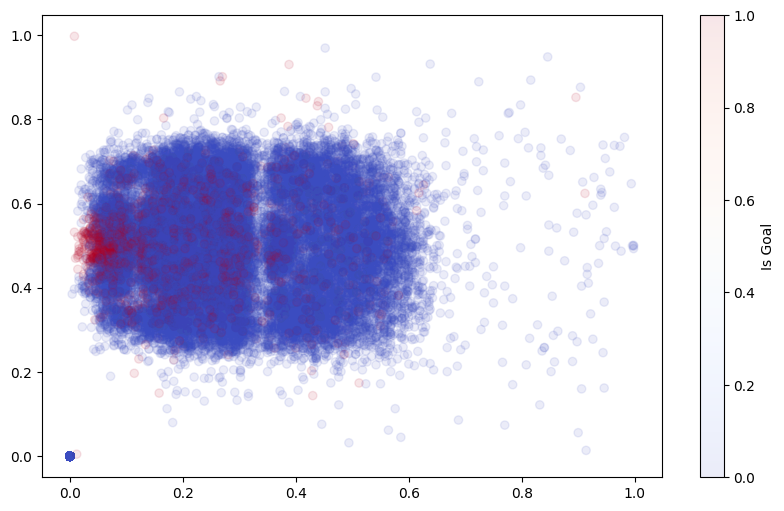

In [13]:
# plot position of each shot
plt.figure(figsize=(10, 6))
plt.scatter(df_shots['fieldpositionX'], df_shots['fieldPositionY'], c=df_shots['isGoal'], cmap='coolwarm', alpha=0.1)
plt.colorbar(label='Is Goal')

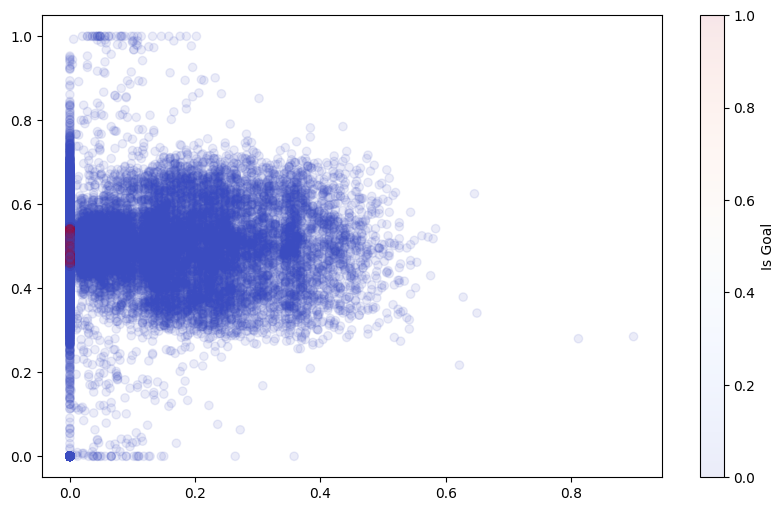

In [14]:
# plot position of each shot
plt.figure(figsize=(10, 6))
plt.scatter(df_shots['fieldPosition2X'], df_shots['fieldPosition2Y'], c=df_shots['isGoal'], cmap='coolwarm', alpha=0.1)
plt.colorbar(label='Is Goal')

# Do machine Learning

In [15]:
df_shots.columns

Index(['seasonType', 'eventId', 'playOrder', 'playId', 'typeId', 'text',
       'shortText', 'period', 'clockValue', 'clockDisplayValue', 'teamId',
       'scoringPlay', 'shootout', 'wallclock', 'goalPositionX',
       'goalPositionY', 'fieldpositionX', 'fieldPositionY', 'fieldPosition2X',
       'fieldPosition2Y', 'athleteId', 'participant', 'updateDateTime',
       'isGoal', 'shotDistance', 'shotAngle', 'shooterPosition'],
      dtype='object')

In [21]:
# train test split
from sklearn.model_selection import train_test_split

X = df_shots[['shotDistance', 'shotAngle', 'shooterPosition', 'clockValue']]
# use pd.get_dummies to convert shooterPosition to one-hot encoding
X = pd.get_dummies(X, columns=['shooterPosition'], dtype=int)
y = df_shots['isGoal']

from sklearn.preprocessing import StandardScaler    
scaler = StandardScaler()
X[['shotDistance', 'shotAngle', 'clockValue']] = scaler.fit_transform(X[['shotDistance', 'shotAngle', 'clockValue']])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(25168, 7) (6292, 7) (25168,) (6292,)


In [22]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# evaluate on test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Accuracy: 0.893674507310871
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


c:\Users\caele\.conda\envs\neuralnets2024\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle

class ProportionalBatchGenerator(Sequence):
    def __init__(self, X, y, batch_size):
        super().__init__()
        self.X = X
        self.y = y
        self.batch_size = batch_size

        # Group indices by class
        self.indices_by_class = {}
        for class_label in np.unique(y):
            self.indices_by_class[class_label] = np.where(y == class_label)[0]
        
        # Compute the proportion of each class
        self.class_proportions = {
            class_label: len(indices) / len(y) 
            for class_label, indices in self.indices_by_class.items()
        }

        # Check if batch size allows proportional representation
        self._check_batch_size()

        # Shuffle indices initially
        self.indices_by_class = {k: shuffle(v) for k, v in self.indices_by_class.items()}
        self.on_epoch_end()

    def _check_batch_size(self):
        """
        Ensure the batch size is large enough to represent all class proportions.
        """
        for class_label, proportion in self.class_proportions.items():
            if proportion * self.batch_size < 1:
                raise ValueError(
                    f"Batch size {self.batch_size} is too small to proportionally "
                    f"represent class {class_label}, which requires at least "
                    f"{int(1 / proportion)} samples per batch."
                )

    def __len__(self):
        # Total number of batches per epoch
        return int(np.ceil(len(self.y) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = []
        
        # Determine how many samples to draw for each class based on the proportions
        for class_label, proportion in self.class_proportions.items():
            num_samples = int(round(proportion * self.batch_size))
            indices = self.indices_by_class[class_label]
            
            # Add samples to the batch
            if len(indices) > 0:
                selected = indices[:num_samples]
                self.indices_by_class[class_label] = np.concatenate([indices[num_samples:], indices[:num_samples]])
                batch_indices.extend(selected)

        # Handle leftover slots if rounding caused the total to be less than batch_size
        if len(batch_indices) < self.batch_size:
            extra_needed = self.batch_size - len(batch_indices)
            remaining_indices = [
                idx for indices in self.indices_by_class.values() for idx in indices
            ]
            batch_indices.extend(remaining_indices[:extra_needed])

        # Shuffle the batch indices for variety
        batch_indices = shuffle(batch_indices)

        # Generate batch data
        X_batch = self.X[batch_indices]
        y_batch = self.y[batch_indices]
        return X_batch, y_batch

    def on_epoch_end(self):
        # Reshuffle data at the end of each epoch
        self.indices_by_class = {k: shuffle(v) for k, v in self.indices_by_class.items()}

In [26]:
train_gen = ProportionalBatchGenerator(X_train.values, y_train.values, batch_size=32)

197/197 [==============================] - 0s 1ms/step
Accuracy: 0.8742848061029879
Precision: 0.2540322580645161
Recall: 0.09417040358744394
F1 Score: 0.13740458015267176


Text(0.5, 1.0, 'Model Accuracy')

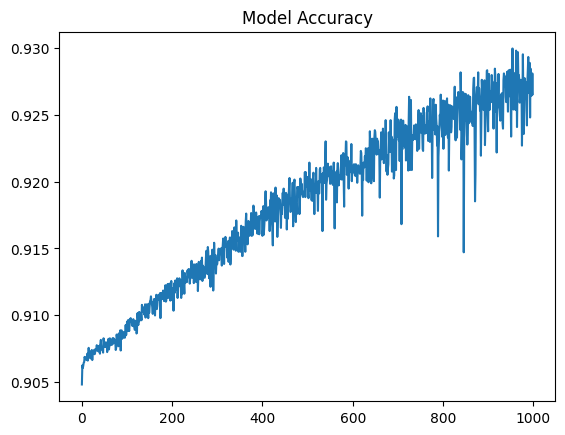

In [36]:
from keras.layers import Input, Dense
from keras.models import Model
import keras

from keras.callbacks import ReduceLROnPlateau
lr_reducer = ReduceLROnPlateau(factor=0.1, cooldown=0, patience=5, min_lr=0.00001)

def res_block(x):
    """Residual block"""
    x_shortcut = x
    x = Dense(64, activation=keras.activations.relu)(x)
    x = Dense(64, activation=keras.activations.relu)(x)
    x = keras.layers.add([x, x_shortcut])
    return keras.activations.relu(x)

input_layer = Input(shape=(X_train.shape[1],))
x = Dense(64, activation=keras.activations.relu)(input_layer)
x = res_block(x)
x = res_block(x)
x = res_block(x)
output_layer = Dense(1, activation=keras.activations.sigmoid)(x)
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history=model.fit(train_gen, epochs=1000, verbose=0)

# evaluate on test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Model Accuracy')